# Facebook Message Analyzer



<b> Current Features For a Given Chat: </b>
<ul> 
    <li> Number of Messages Sent </li> 
    <li> Messages Sent Over Time </li> 
    <li> Average Word Count </li>
    <li> Most Active Conversations </li>
</ul>

Written by Jeffrey He in 2018

In [22]:
import os
import json
import numpy as np
import pylab as pl
import datetime

CURRENT_DIRECTORY = os.getcwd()
NUMBER_TO_ANALYZE = 5000
MESSAGE_THRESHOLD = 3

In [23]:
def get_json_data(chat):
    try:
        json_location = CURRENT_DIRECTORY + "/messages/" + chat + "/message.json"
        with open(json_location) as json_file:
            json_data = json.load(json_file)
            return json_data
    except IOError:
        pass # some things the directory aren't messages (DS_Store, stickers_used, etc.)

In [24]:
chats = os.listdir(CURRENT_DIRECTORY + "/messages")[:NUMBER_TO_ANALYZE]
sorted_chats = []
final_data_messages = {}
final_data_times = {}
final_data_words = {}
invalid_message_count = 0

In [25]:
print('Analyzing ' + str(min(NUMBER_TO_ANALYZE, len(chats))) + ' chats...')

for chat in chats:
    json_data = get_json_data(chat)
    if json_data != None:
        messages = json_data["messages"]
        if len(messages) >= MESSAGE_THRESHOLD:
            sorted_chats.append((len(messages), chat, messages))

sorted_chats.sort(reverse=True)

print('Finished processing chats...')

Analyzing 53 chats...
Finished processing chats...


In [26]:
for i, (messages, chat, messages) in enumerate(sorted_chats):
    number_messages = {}
    person_to_times = {}
    number_words = {}

    print(str(i) + " - " + str(len(messages)) + " messages - " + str(chat))

    for message in messages:
        try:
            name = message["sender_name"]
            time = message["timestamp_ms"]
            message_content = message["content"]

            number_messages[name] = number_messages.get(name, 0)
            number_messages[name] += 1

            person_to_times[name] = person_to_times.get(name, [])
            person_to_times[name].append(datetime.datetime.fromtimestamp(time/1000.0))

            number_words[name] = number_words.get(name, [])
            number_words[name].append(len(message_content.split()))
        except KeyError:
            # happens for special cases like users who deactivated, unfriended, blocked
            invalid_message_count += 1

    final_data_messages[i] = number_messages
    final_data_times[i] = person_to_times
    final_data_words[i] = number_words

print('Found ' + str(invalid_message_count) + ' invalid messages...')
print('Found ' + str(len(sorted_chats)) + ' chats with ' + str(MESSAGE_THRESHOLD) + ' messages or more')

0 - 223 messages - DiegoCachay_Hsu9XJzecw
1 - 47 messages - nicholasshropshire_nml0d7oyma
2 - 19 messages - KevinRankine_FNioiTcLFg
3 - 16 messages - AnikoAlbert_HPCEmF4D9Q
4 - 6 messages - ryanallred_3l_q0czqra
Found 0 invalid messages...
Found 5 chats with 3 messages or more


In [27]:
def plot_num_messages(chat_number):
    plotted_data = final_data_messages[chat_number]
    X = np.arange(len(plotted_data))
    pl.bar(X, list(plotted_data.values()), align='center', width=0.5, color = 'r', bottom = 0.3)
    pl.xticks(X, plotted_data.keys(), rotation = 90)
    pl.title('Number of Messages Sent')
    pl.tight_layout()
    pl.show()
    
def plot_histogram_time(chat_number):
    person_to_times = final_data_times[chat_number]
    pl.xlabel('Time')
    pl.ylabel('Number of Messages')
    pl.title('# of Messages Over Time')
    colors = ['b', 'r', 'c', 'm', 'y', 'k', 'w', 'g']
    for i , person in enumerate(person_to_times):
        plotted_data = person_to_times[person]
        pl.hist(plotted_data, 100, label=person, facecolor=colors[i % len(colors)])
    pl.legend()
    pl.xticks(rotation=90)
    pl.tight_layout()
    pl.show()
    

# Number of messages by time of day    
def plot_histogram_hour(chat_number):
    time_data = final_data_times[chat_number]
    pl.xlabel('Hour')
    pl.ylabel('Number of Messages')
    pl.title('Messages by Hour')
    for person in time_data:
        message_hours = list()
        for message in time_data[person]:
            message_hours.append(message.hour)
        pl.hist(message_hours, 100, alpha=0.5, width=0.5, label=person)
    pl.xticks(np.arange(24), [f"{i % 12} PM" if i > 12 else "12 PM" if i == 12 else "12 AM" if i == 0 else f"{i % 12} AM" for i in range(24)], rotation = 90)
    pl.legend()
    pl.show()
    
            
def plot_histogram_words(chat_number):
    temp = {}
    for person in final_data_words[chat_number]:
        temp[person] = np.average(final_data_words[chat_number][person])
    plotted_data = temp
    X = np.arange(len(plotted_data))
    pl.bar(X, list(plotted_data.values()), align='center', width=0.5, color = 'r', bottom = 0.3)
    pl.xticks(X, plotted_data.keys(), rotation = 90)
    pl.title('Average Word Count')
    pl.tight_layout()
    pl.show()
    
    
# Lists most active conversations
def list_active_chats():
    data = dict()
    for chat in final_data_words:
        total_words = 0
        a = dict()
        for person in final_data_words[chat]:
            num_words = np.sum(final_data_words[chat][person])
            a.update({person: num_words})
            total_words += num_words
        for person in final_data_words[chat]:
            num_words = np.sum(final_data_words[chat][person])
            a[person] = '{:.2%} of all words'.format(num_words / total_words)
        a['total'] = f"{total_words} words"
        data[chat] = a
    print("Most active to least active conversations")
    for chat, stats in data.items():
        print("########")
        for label, num in stats.items():
            print(f'{label}: {num}')

    
def plot(chat_number):
    #plot_num_messages(chat_number)
    #plot_histogram_time(chat_number)
    #plot_histogram_words(chat_number)
    plot_histogram_hour(chat_number)
    list_active_chats()

Hours of messages sent 
Alex Rankine: [20, 19, 19, 19, 19, 19, 10, 8, 7, 19, 13, 19]
Hours of messages sent 
Kevin Rankine: [19, 19, 19, 19, 10, 19, 9]


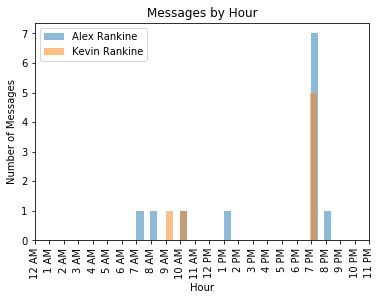

Most active to least active conversations
########
Alex Rankine: 36.10% of all words
Diego Cachay: 63.90% of all words
total: 1424 words
########
Nicholas Shropshire: 56.90% of all words
Alex Rankine: 43.10% of all words
total: 406 words
########
Alex Rankine: 62.82% of all words
Kevin Rankine: 37.18% of all words
total: 78 words
########
Aniko Albert: 27.27% of all words
Alex Rankine: 72.73% of all words
total: 55 words
########
Alex Rankine: 42.11% of all words
Ryan Allred: 57.89% of all words
total: 19 words


In [28]:
plot(2)